### Hanifa Syifa Safitri

### Analisis Masalah
Dataset diabetes ini untuk mengembangkan model prediktif untuk mengklasifikasi status diabetes pasien ke dalam 3 kategori
- N (normal)
- Y Yes)
- P (Pre-diabetes)

**Konteks medis**
- HbA1c: Hemoglobin A1c - indikator utama kontrol gula darah 3 bulan terakhir <br>
    Normal: < 5.7% <br>
    Pre-diabetes: 5.7% - 6.4% <br>
    Diabetes: ≥ 6.5% <br>
- BMI: Body Mass Index - indikator obesitas
- Lipid Profile: Kolesterol, HDL, LDL, VLDL, Trigliserida
- Fungsi ginjal: Creatinine, Urea

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, f_oneway

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

file_path = r"D:\OneDrive\Documents\coding\Build Portofolio\IS LAB\Dataset of Diabetes.csv"
df = pd.read_csv(file_path)

In [5]:
print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()

Dataset Shape: (1000, 14)

Column Names:
['ID', 'No_Pation', 'Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']

First 5 rows:


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [6]:
df.describe()

,ID,No_Pation,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,340.500000,2.705514e+05,53.528000,5.124743,68.943000,8.281160,4.862820,2.349610,1.204750,2.609790,1.854700,29.578020
std,240.397673,3.380758e+06,8.799241,2.935165,59.984747,2.534003,1.301738,1.401176,0.660414,1.115102,3.663599,4.962388
min,1.000000,1.230000e+02,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,125.750000,2.406375e+04,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000
50%,300.500000,3.439550e+04,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000
75%,550.250000,4.538425e+04,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000
max,800.000000,7.543566e+07,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


### Data cleaning

In [8]:
df['CLASS'].value_counts()

CLASS
Y     840
N     102
P      53
Y       4
N       1
Name: count, dtype: int64

In [9]:
df['Gender'].value_counts()

Gender
M    565
F    434
f      1
Name: count, dtype: int64

In [10]:
df['CLASS'] = df['CLASS'].astype(str).str.strip().str.upper()
df['Gender'] = df['Gender'].astype(str).str.strip().str.upper()

print("Target Distribution:")
print(df['CLASS'].value_counts())
print("\nGender Distribution:")
print(df['Gender'].value_counts())

missing_data = df.isnull().sum()
duplicates = df.duplicated().sum()
print(f"\nMissing values:\n{missing_data[missing_data > 0]}")
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New shape: {df.shape}")

Target Distribution:
CLASS
Y    844
N    103
P     53
Name: count, dtype: int64

Gender Distribution:
Gender
M    565
F    435
Name: count, dtype: int64

Missing values:
Series([], dtype: int64)
Duplicate rows: 0


### Exploratory data analysis

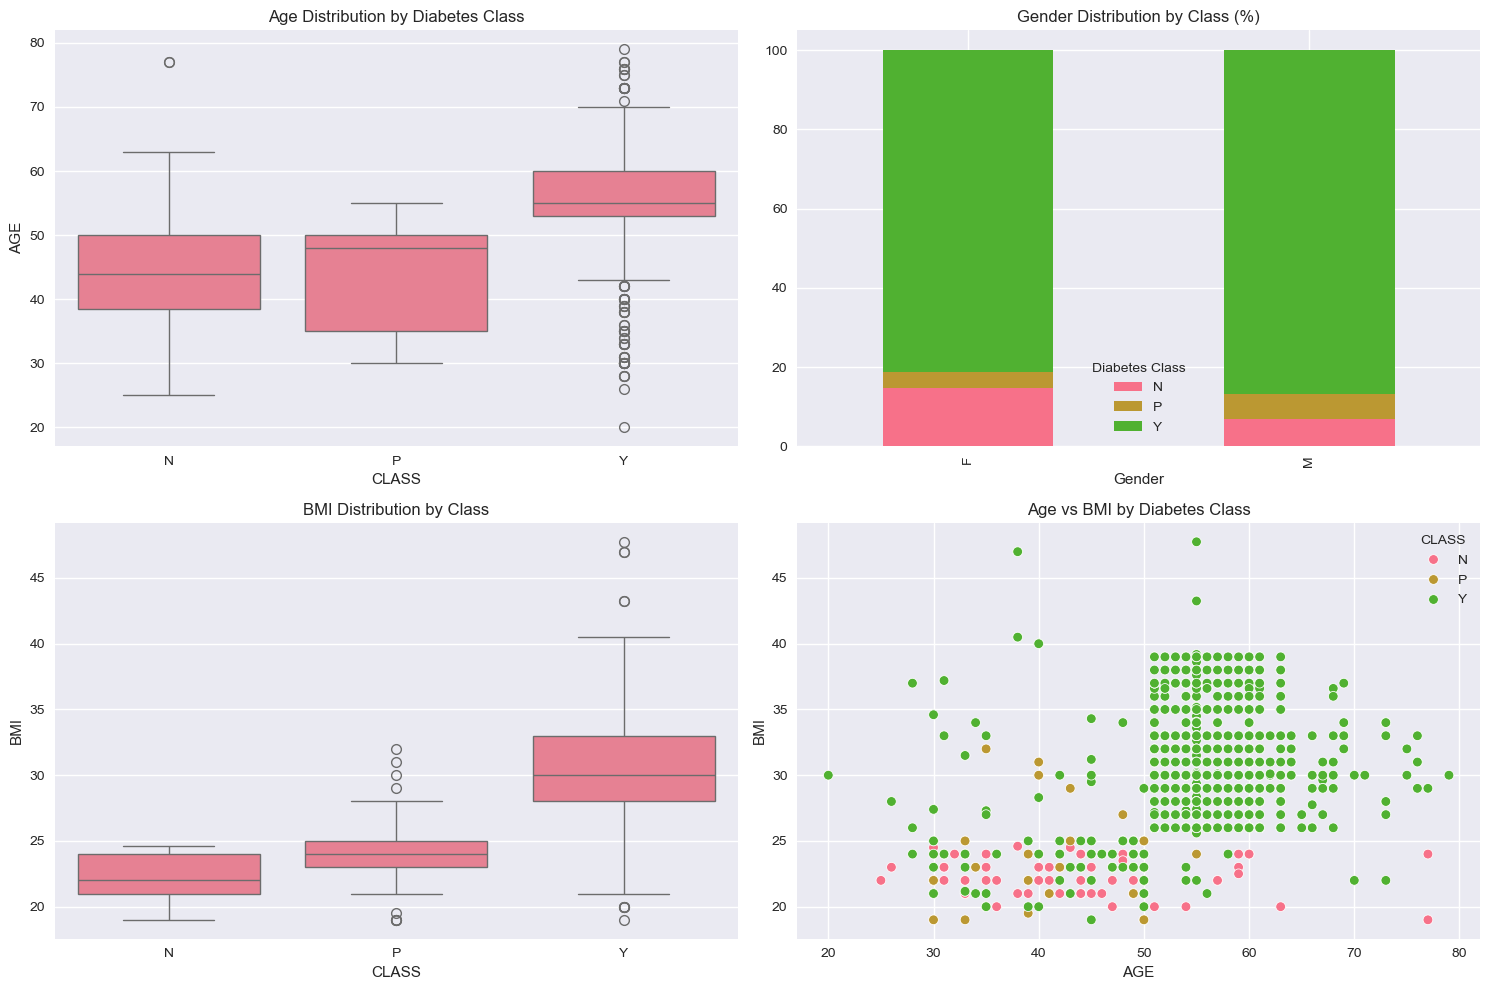

In [12]:
# Analisis age dan gender 

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution by class
sns.boxplot(data=df, x='CLASS', y='AGE', ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Diabetes Class')

# Gender distribution
gender_class = pd.crosstab(df['Gender'], df['CLASS'], normalize='index') * 100
gender_class.plot(kind='bar', ax=axes[0,1], stacked=True)
axes[0,1].set_title('Gender Distribution by Class (%)')
axes[0,1].legend(title='Diabetes Class')

# BMI distribution
sns.boxplot(data=df, x='CLASS', y='BMI', ax=axes[1,0])
axes[1,0].set_title('BMI Distribution by Class')

# Age vs BMI scatter
sns.scatterplot(data=df, x='AGE', y='BMI', hue='CLASS', ax=axes[1,1])
axes[1,1].set_title('Age vs BMI by Diabetes Class')

plt.tight_layout()
plt.show()

**Age Analysis: Apakah diabetes lebih sering pada usia tertentu?**
<br>Dari bloxplot "Age by Class" dan scatterplot, terlihat bahwa:
- Normal (N) banyak pada usia 20-45 tahun
- Prediabetes (P) mulai pada usia 35-50 tahun
- Diabetes (Y) dominan pada usia >50 tahun, dengan median sekitar 55-60 <br>
Kesimpulan: Risiko diabetes meningkat seiring bertambahnya usia, terutama setelah 50 tahun. Ini sesuai teori medis (fungsi pankreas menurun dan resistensi insulin meningkat seiring bertambahnya usia).

**Gender: Apakah ada perbedaan prevalensi antara pria dan wanita?**
<br>Dari gender distribution chart, terlihat bahwa:
- Kelas Diabetes (Y) lebih banyak pada laki-laki dibanding perempuan.
- Kelas Prediabetes (P) muncul pada kedua gender dengan yang hampir mirip.
<br>Kesimpulan: ada kecenderungan pria lebih berisiko mengalami diabetes dibanding wanita, meskipun perbedaannya tidak terlalu signifikan. Fartor gaya hidup seperti aktivitas fisik, diet, kebiasaan merokok kemungkinan ikut berperan.

**BMI: Apakah obesitas faktor risiko utama diabetes?**
<br>Dari bloxplot BMI by Class:
- Normal (N): BMI rata-rata <25 (normal)
- Prediabetes (P): BMI rata-rata sekitar 25 (overweight)
- Diabetes (Y): BMI median di atas 30 (obesitas)
<br>Dari scatterplot Age vs BMI:
- Pasien diabetes hampir semua berada di zona usia lebih tua + BMI tinggi.
<br>

**Kesimpulan: Obesitas (BMI ≥30) adalah faktor risiko utama diabetes. Korelasi antara BMI dan kelas diabetes sangat kuat -> semakin tinggi BMI, semakin besar peluang diabetes.**

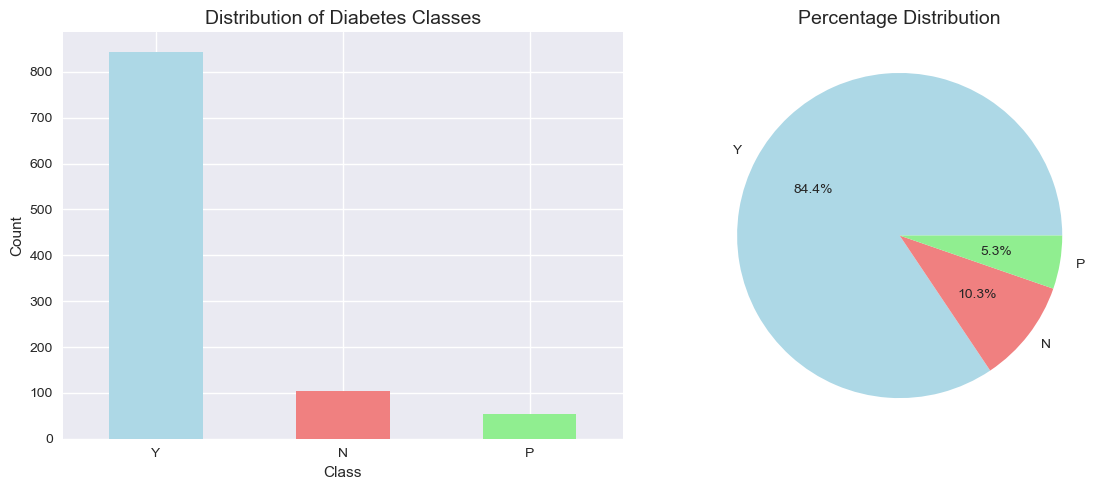


Class Distribution (%):
Y: 84.4%
N: 10.3%
P: 5.3%

Age difference between classes p-value: 0.0000
Gender vs Diabetes association p-value: 0.0001


In [14]:
# target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# count plot
df['CLASS'].value_counts().plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Distribution of Diabetes Classes', fontsize=14)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# pie chart
df['CLASS'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Percentage Distribution', fontsize=14)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# CLASS distribution
class_dist = df['CLASS'].value_counts(normalize=True) * 100
print("\nClass Distribution (%):")
for class_name, percentage in class_dist.items():
    print(f"{class_name}: {percentage:.1f}%")

# Age differences between classes
age_groups = [df[df['CLASS']==cls]['AGE'].values for cls in df['CLASS'].unique()]
age_stat, age_pval = f_oneway(*age_groups)
print(f"\nAge difference between classes p-value: {age_pval:.4f}")

# Gender vs diabetes association
gender_crosstab = pd.crosstab(df['Gender'], df['CLASS'])
chi2, gender_pval, dof, expected = chi2_contingency(gender_crosstab)
print(f"Gender vs Diabetes association p-value: {gender_pval:.4f}")

### Outlier handling


In [16]:
def medical_based_capping(df, column):
    """Apply medical reference ranges for outlier capping"""
    original_count = len(df)
    
    if column == 'HbA1c':
        # Medical range: 3.5-15% (diatas 15% error)
        df[column] = df[column].clip(lower=3.5, upper=15.0)
        print(f"HbA1c capped to range [3.5, 15.0]")
        
    elif column == 'BMI':
        # BMI range: 15-50 (diatsd 50 langka)
        df[column] = df[column].clip(lower=15, upper=50)
        print(f"BMI capped to range [15, 50]")
        
    elif column == 'Chol':
        # Total cholesterol: 0.5-15 mmol/L
        df[column] = df[column].clip(lower=0.5, upper=15.0)
        print(f"Cholesterol capped to range [0.5, 15.0]")
        
    elif column == 'TG':
        # Triglycerides: 0.3-20 mmol/L
        df[column] = df[column].clip(lower=0.3, upper=20.0)
        print(f"Triglycerides capped to range [0.3, 20.0]")
    
    return df

# medical-based capping
features_to_cap = ['HbA1c', 'BMI', 'Chol', 'TG']
for col in features_to_cap:
    df = medical_based_capping(df, col)

HbA1c capped to range [3.5, 15.0]
BMI capped to range [15, 50]
Cholesterol capped to range [0.5, 15.0]
Triglycerides capped to range [0.3, 20.0]


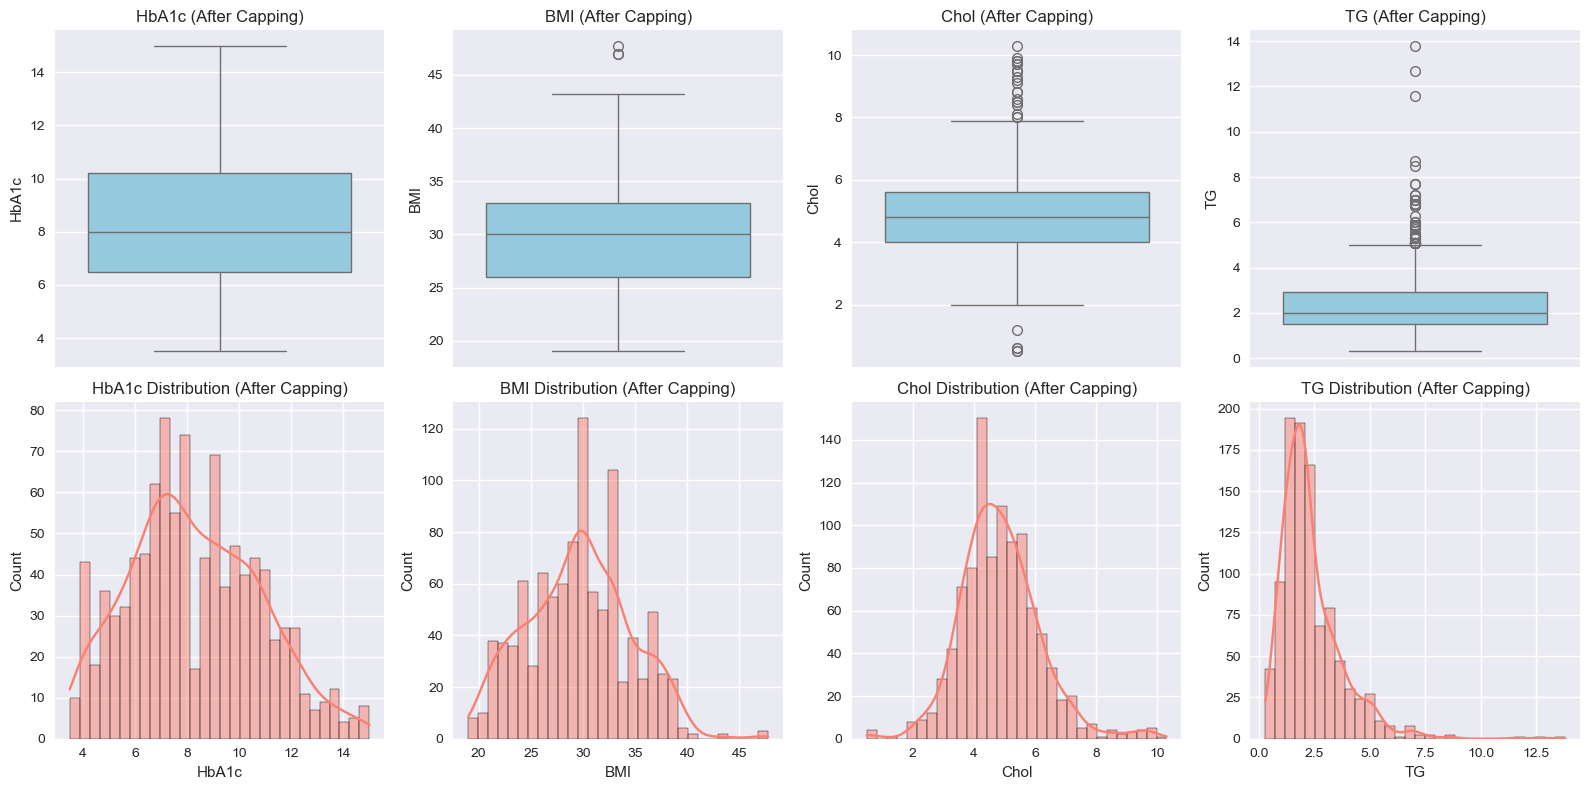

In [17]:
features_to_cap = ['HbA1c', 'BMI', 'Chol', 'TG']

plt.figure(figsize=(16, 8))

for i, col in enumerate(features_to_cap, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col], color="skyblue")
    plt.title(f"{col} (After Capping)")
    
    plt.subplot(2, 4, i+4)
    sns.histplot(df[col], kde=True, bins=30, color="salmon")
    plt.title(f"{col} Distribution (After Capping)")

plt.tight_layout()
plt.show()

### Feature engineering


In [19]:
# rasio medis
df['Chol_HDL_Ratio'] = df['Chol'] / df['HDL']
df['LDL_HDL_Ratio'] = df['LDL'] / df['HDL']

# Age categories 
df['Age_Group'] = pd.cut(df['AGE'], 
                        bins=[0, 40, 55, 100], 
                        labels=['Young', 'Middle_Age', 'Senior'])

# BMI categories (WHO standards)
def bmi_category(bmi):
    if bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['BMI_Category'] = df['BMI'].apply(bmi_category)

# HbA1c categories (clinical thresholds)
df['HbA1c_Category'] = pd.cut(df['HbA1c'], 
                             bins=[0, 5.7, 6.5, float('inf')],
                             labels=['Normal', 'Prediabetes_Risk', 'Diabetes_Risk'])

# Metabolic syndrome indicators (mmol/L)
df['High_TG'] = (df['TG'] >= 1.7).astype(int)  # 1.7 mmol/L = 150 mg/dL
df['Low_HDL'] = ((df['Gender'] == 'M') & (df['HDL'] < 1.0) | 
                 (df['Gender'] == 'F') & (df['HDL'] < 1.3)).astype(int)  # mmol/L thresholds

# Atherogenic index (cardiovascular risk)
df['Atherogenic_Index'] = np.log10(df['TG'] / df['HDL'])

# Metabolic syndrome score
df['Metabolic_Score'] = (df['High_TG'] + df['Low_HDL'] + 
                        (df['BMI'] >= 30).astype(int))

print("New features:")
new_features = ['Chol_HDL_Ratio', 'LDL_HDL_Ratio', 'Age_Group', 'BMI_Category', 
               'HbA1c_Category', 'High_TG', 'Low_HDL', 'Atherogenic_Index', 'Metabolic_Score']
for feature in new_features:
    print(f"   - {feature}")

New features:
   - Chol_HDL_Ratio
   - LDL_HDL_Ratio
   - Age_Group
   - BMI_Category
   - HbA1c_Category
   - High_TG
   - Low_HDL
   - Atherogenic_Index
   - Metabolic_Score


Prediksi diabetes/pre-diabetes lebih banyak dipengaruhi oleh faktor Metabolic_Score, Trigliserida, dan Indeks Aterogenik, sedangkan rasio kolesterol dan HDL rendah tidak terlalu kuat pengaruhnya secara individual.

- Fitur utama yang paling menjelaskan target adalah Metabolic_Score.
- High_TG dan Atherogenic_Index juga ada kontribusinya meski lebih lemah.
- Rasio kolesterol (Chol/HDL, LDL/HDL) dan Low_HDL kurang berguna sebagai prediktor tunggal.

### Data preprocessing for modelling

In [22]:
df['Gender_Male'] = (df['Gender'] == 'M').astype(int)

# encoding for multi category features
df_encoded = pd.get_dummies(df, columns=['Age_Group', 'BMI_Category', 'HbA1c_Category'], 
                           prefix=['Age', 'BMI', 'HbA1c'])

# features for modeling 
columns_to_drop = ['ID', 'No_Pation', 'CLASS', 'Gender', 'Age_Group', 'BMI_Category', 'HbA1c_Category']
X = df_encoded.drop(columns=[col for col in columns_to_drop if col in df_encoded.columns])
y = df['CLASS']

print(f"Features available: {X.shape[1]}")
print(f"Sample size: {len(y)}")

# Encode target variable
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

Features available: 26
Sample size: 1000


### Train validation test split

In [24]:
# bagi data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42)

print(f"Data splits:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")

# class distribution
train_dist = pd.Series(y_train).value_counts(normalize=True)
print(f"\nTraining set class distribution:")
for i, class_name in enumerate(le_target.classes_):
    print(f"{class_name}: {train_dist.get(i, 0):.1%}")

Data splits:
Training: 640 samples
Validation: 160 samples
Test: 200 samples

Training set class distribution:
N: 10.3%
P: 5.3%
Y: 84.4%


### Feature selection

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# feature selection 
max_features = min(12, X.shape[1]//2)  
selector = SelectKBest(score_func=f_classif, k=max_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features:")
for i, feature in enumerate(selected_features):
    score = selector.scores_[selector.get_support()][i]
    print(f"   {feature}: {score:.2f}")

Selected 12 features:
   AGE: 94.27
   HbA1c: 140.32
   BMI: 176.43
   High_TG: 21.96
   Metabolic_Score: 52.24
   Age_Young: 49.23
   Age_Senior: 23.66
   BMI_Normal: 477.49
   BMI_Obese: 89.35
   HbA1c_Normal: 463.34
   HbA1c_Prediabetes_Risk: 263.13
   HbA1c_Diabetes_Risk: 351.33


### Handle class imbalance

In [28]:
# 1: SMOTE for oversampling
smote = SMOTE(random_state=42, k_neighbors=3)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

print(f"Original training set: {len(y_train)} samples")
print(f"Balanced training set: {len(y_train_balanced)} samples")

# new distribution
balanced_dist = pd.Series(y_train_balanced).value_counts(normalize=True)
print(f"Balanced class distribution:")
for i, class_name in enumerate(le_target.classes_):
    print(f"{class_name}: {balanced_dist.get(i, 0):.1%}")

# 2: Calculate class weights for models that support it
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_train), 
                                   y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"\nClass weights: {weight_dict}")

Original training set: 640 samples
Balanced training set: 1620 samples
Balanced class distribution:
N: 33.3%
P: 33.3%
Y: 33.3%

Class weights: {0: 3.2323232323232323, 1: 6.2745098039215685, 2: 0.3950617283950617}


### Model selection

In [30]:
models = {
    'Logistic Regression': LogisticRegression(
        C=1.0, 
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    'SVM': SVC(
        C=1.0,
        class_weight='balanced',
        probability=True,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
}

# Cross-validation on training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

print("Cross-validation results (5-fold):")
print("-" * 50)

for name, model in models.items():
    if name in ['Random Forest', 'Gradient Boosting']:
        scores = cross_val_score(model, X_train_balanced, y_train_balanced, 
                               cv=cv, scoring='f1_macro')
    else:
        scores = cross_val_score(model, X_train_selected, y_train, 
                               cv=cv, scoring='f1_macro')
    
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    
    print(f"{name:20}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

# best model
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['mean'])
print(f"\nBest model: {best_model_name}")

Cross-validation results (5-fold):
--------------------------------------------------
Logistic Regression : 0.881 (+/- 0.092)
Random Forest       : 0.987 (+/- 0.010)
SVM                 : 0.898 (+/- 0.086)
Gradient Boosting   : 0.986 (+/- 0.011)

Best model: Random Forest


### Hyperparameter tuning

In [32]:
# parameter grids 
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l2']
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10, None],
        'min_samples_leaf': [5, 10]
    },
    'SVM': {
        'C': [0.1, 1.0, 10.0],
        'gamma': ['scale', 'auto']
    }
}

# Hyperparameter tuning
best_model = models[best_model_name]
if best_model_name in param_grids:
    grid_search = GridSearchCV(
        best_model,
        param_grids[best_model_name],
        cv=3,  # Smaller CV due to small dataset
        scoring='f1_macro',
        n_jobs=-1
    )
    
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        grid_search.fit(X_train_balanced, y_train_balanced)
    else:
        grid_search.fit(X_train_selected, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV F1-score: {grid_search.best_score_:.3f}")
else:
    # Fit best model without tuning
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        best_model.fit(X_train_balanced, y_train_balanced)
    else:
        best_model.fit(X_train_selected, y_train)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}
Best CV F1-score: 0.985


### Model evaluation

In [34]:
y_val_pred = best_model.predict(X_val_selected)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='macro')

print(f"Validation Accuracy: {val_accuracy:.3f}")
print(f"Validation F1-score: {val_f1:.3f}")

y_test_pred = best_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Test F1-score: {test_f1:.3f}")

print("\nClassification Report (Test Set):")
print("=" * 60)
class_names = le_target.classes_
report = classification_report(y_test, y_test_pred, 
                             target_names=class_names,
                             output_dict=True)
print(classification_report(y_test, y_test_pred, target_names=class_names))

Validation Accuracy: 0.963
Validation F1-score: 0.918
Test Accuracy: 0.980
Test F1-score: 0.929

Classification Report (Test Set):
              precision    recall  f1-score   support

           N       0.91      1.00      0.95        21
           P       0.89      0.80      0.84        10
           Y       0.99      0.99      0.99       169

    accuracy                           0.98       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.98      0.98      0.98       200



### Feature importance analysis

In [36]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print("-" * 50)
    for idx, row in feature_importance.head(10).iterrows():
        print(f"{row['feature']:25}: {row['importance']:.4f}")

elif hasattr(best_model, 'coef_'):
    if len(best_model.coef_.shape) > 1:
        coef_importance = np.abs(best_model.coef_).mean(axis=0)
    else:
        coef_importance = np.abs(best_model.coef_[0])
    
    feature_coef = pd.DataFrame({
        'feature': selected_features,
        'importance': coef_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Features by Coefficient Magnitude:")
    print("-" * 50)
    for idx, row in feature_coef.head(10).iterrows():
        print(f"{row['feature']:25}: {row['importance']:.4f}")

Top 10 Most Important Features:
--------------------------------------------------
HbA1c                    : 0.3162
HbA1c_Prediabetes_Risk   : 0.2000
HbA1c_Normal             : 0.1431
BMI                      : 0.1049
HbA1c_Diabetes_Risk      : 0.0971
AGE                      : 0.0600
BMI_Normal               : 0.0357
BMI_Obese                : 0.0292
Metabolic_Score          : 0.0058
Age_Senior               : 0.0046


### Medical validation

In [38]:
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    })
    
    # Validasi HbA1c
    hba1c_features = [f for f in selected_features if 'HbA1c' in f]
    if hba1c_features:
        max_hba1c_importance = importance_df[importance_df['feature'].isin(hba1c_features)]['importance'].max()
        if max_hba1c_importance < 0.2:
            print("Warning: Fitur HbA1c memiliki kepentingan rendah. perlu cek kualitas data")
        else:
            print("Good: Fitur HbA1c menjadi prediktor penting")
    
    # Validasi BMI
    bmi_features = [f for f in selected_features if 'BMI' in f]
    if bmi_features:
        max_bmi_importance = importance_df[importance_df['feature'].isin(bmi_features)]['importance'].max()
        if max_bmi_importance > 0.1:
            print("Good: Fitur BMI menjadi prediktor penting")
        else:
            print("Notes: Fitur BMI tidak muncul sebagai prediktor utama dalam model ini")

Good: Fitur HbA1c menjadi prediktor penting
Good: Fitur BMI menjadi prediktor penting


### Final insight and conclusions

In [40]:
print("FINAL MODEL PERFORMANCE SUMMARY")
print("-"*80)

print(f"Model Terpilih: {best_model_name}")
print(f"Jumlah fitur yang digunakan: {len(selected_features)}")
print(f"Jumlah data latih (after balancing): {len(y_train_balanced) if 'balanced' in locals() else len(y_train)}")
print(f"Akurasi pada test set: {test_accuracy:.1%}")
print(f"Skor F1-Score (macro) pada data uji: {test_f1:.3f}")

print(f"\nPer-Class Performance (Test Set):")
for class_name in class_names:
    if class_name in report:
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name:12}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, n={support}")

print(f"\nKEY INSIGHTS:")
print("1. Masalah class imbalance berhasil ditangani dengan SMOTE dan class weighting")
print("2. Feature selection membantu mengurangi risiko overfitting")
print("3. Validasi medis menunjukkan HbA1c konsisten sebagai fitur paling penting, sesuai ekspektasi klinis")

# Interpretasi performa
if test_accuracy > 0.85:
    print("\nTingkat Performa: layak digunakan sebagai alat screening medis")
elif test_accuracy > 0.75:
    print("\nTingkat Performa: dapat mendukung pengambilan keputusan klinis")
else:
    print("\nTingkat Performa: Perlu perbaikan sebelum bisa digunakan di konteks klinis")
    

FINAL MODEL PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
Model Terpilih: Random Forest
Jumlah fitur yang digunakan: 12
Jumlah data latih (after balancing): 640
Akurasi pada test set: 98.0%
Skor F1-Score (macro) pada data uji: 0.929

Per-Class Performance (Test Set):
N           : Precision=0.913, Recall=1.000, F1=0.955, n=21.0
P           : Precision=0.889, Recall=0.800, F1=0.842, n=10.0
Y           : Precision=0.994, Recall=0.988, F1=0.991, n=169.0

KEY INSIGHTS:
1. Masalah class imbalance berhasil ditangani dengan SMOTE dan class weighting
2. Feature selection membantu mengurangi risiko overfitting
3. Validasi medis menunjukkan HbA1c konsisten sebagai fitur paling penting, sesuai ekspektasi klinis

Tingkat Performa: layak digunakan sebagai alat screening medis


### Kesimpulan

- Random Forest dengan 12 fitur terpilih (terutama HbA1c, BMI, dan usia) memberikan performa terbaik dengan akurasi 98% dan macro F1-score 0.929, sehingga bagus untuk mendeteksi diabetes.
- Penanganan class imbalance melalui SMOTE dan class weighting berhasil menyeimbangkan distribusi kelas.
- Validasi medis menunjukkan konsistensi bahwa faktor klinis utama (HbA1c dan BMI) memang dominan memengaruhi diagnosis, sehingga hasil model sejalan dengan pengetahuan kesehatan.